# Rossmann Store Sales
## Problema de Previsão de Vendas

### Motivação
CFO requisitou essa solução durante uma reunião de resultados mensais;

### Causa Raíz do Problema
Investimento para reforma das lojas;

### Stakeholders
CFO;

### Formato da Solução
Vendas diárias em R$, nos próximos 6 meses;
Problema de predição;
Séries temporais, Regressão e Redes Neurais;
Predições acessadas via celular;

# 0.0 Imports

In [1]:
#Importando bibliotecas
import pandas as pd
import inflection
import math
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from datetime import datetime, timedelta
import numpy as np

## 0.1 Helper Functions

## 0.2 Loading Data

In [2]:
#Carregando dados
df_sales_raw = pd.read_csv('train.csv', low_memory = False)
df_store_raw = pd.read_csv('store.csv', low_memory = False)

In [3]:
#Verificando os dados
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
#Verificando os dados
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 Descrição dos dados

In [6]:
#criando cópia do dataframe inicial
df1 = df_raw.copy()

## 1.1 Rename Columns 

In [7]:
#renomear colunas para facilitar o trabalho futuro
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

new_cols = list(map(snakecase, old_cols))

df1.columns = new_cols

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [10]:
#verificando o tamanho do dataframe
print( 'Number of rows: {}' .format (df1.shape[0]) )
print( 'Number of columns: {}' .format (df1.shape[1]) )

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [11]:
#verificando os tipos dos dados
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
#trocando o tipo dos dados
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [13]:
#verificando a existência de NA's nas colunas 
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [14]:
# competition_distance com valores nulos = não há concorrência próxima
## então substituiremos valores nulos com uma distância exageradamente grande
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) 
                                                              else x)

In [15]:
# competition_open_since_month com valores nulos = não sabemos o mês que o concorrente inaugurou ou não temos concorrente
## seguindo o CRISP-DS, inicialmente, para primeira iteração, vamos considerar que é o mesmo mês da venda.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)

In [16]:
# competition_open_since_year com valores nulos = não sabemos o ano que o concorrente inaugurou ou não temos concorrente
## seguindo o CRISP-DS, inicialmente, para primeira iteração, vamos considerar que é o mesmo ano da venda.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1)

In [17]:
#promo2_since_week com valores nulos = a loja não iniciou na promo2
## seguindo o CRISP-DS, inicialmente, para primeira iteração, vamos considerar que é o mesmo mês da venda.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis=1)


In [18]:
#promo2_since_year com valores nulos = a loja não iniciou na promo2
## seguindo o CRISP-DS, inicialmente, para primeira iteração, vamos considerar que é o mesmo ano da venda.
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis=1)

In [19]:
#promo_interval com valores nulos = a loja não iniciou na promo2
## seguindo o CRISP-DS, inicialmente, para primeira iteração, vamos criar uma nova coluna para explicitar se é promoção ou não
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'Mai', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1.apply(lambda x: 0 if (x['promo_interval'] == 0) else
                               1 if (x['month_map'] in x['promo_interval'].split(',')) 
                               else 0, axis=1)

In [20]:
#verificando a existência de NA's nas colunas
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Data Types

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [23]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

### 1.7.1 Numerical Attributes 

In [24]:
num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'int32' , 'datetime64[ns]'] )

num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns={'index': 'attributes'})

,attributes,mean,median,std,min,max,skew,kurtosis
0,store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304


### 1.7.2 Categorical Attributes 

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

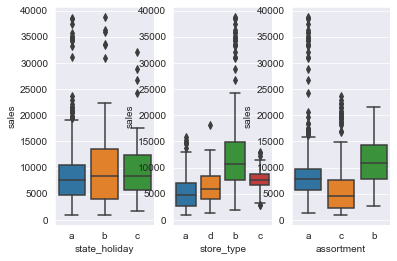

In [26]:
aux = df1[(df1['sales']>0) & (df1['state_holiday']!='0')]

sns.set_style("darkgrid")

fig, ax = plt.subplots(1,3)

sns.boxplot(x='state_holiday', y='sales', data=aux, ax=ax[0])

sns.boxplot(x='store_type', y='sales', data=aux, ax=ax[1])

sns.boxplot(x='assortment', y='sales', data=aux, ax=ax[2])



# 2.0 Feature Engineering

In [27]:
df2 = df1.copy()

In [39]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 2.1 Mapa mental

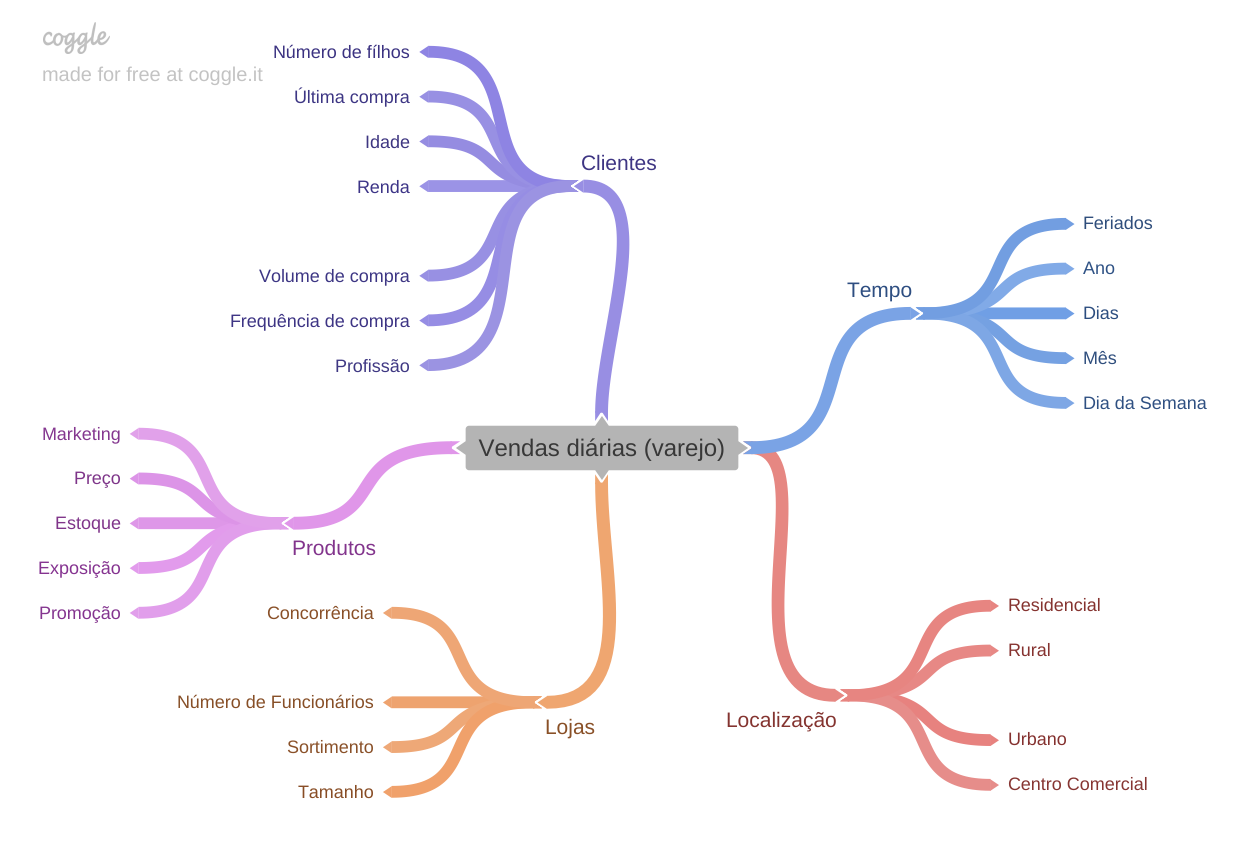

In [28]:
# Mapa mental para representar as vendas diárias no ramo varejista
Image('Vendas_dirias_varejo.png')

## 2.2 Hipóteses

Como não temos informações de Clientes e de Localização, vamos focar em hipóteses geradas por Lojas, Produtos e Tempo.

**1**. Lojas com maior sortimento devem vender mais;

**2**. Lojas com concorrente perto devem vender menos;

**3**. lojas com Concorrentes mais antigos devem vender menos;

**4**. Lojas com promoções ativas por mais tempo devem vender mais;

**5**. Lojas com mais dias de promoção deveriam vender mais;

**6**. Lojas com mais promoções consecutivas deveriam vender mais;

**7**. Lojas abertas no Natal deveriam vender mais;

**8**. Lojas deveriam vender mais ao longo dos anos;

**9**. Lojas deveriam vender mais no segundo semestre do ano;

**10**. Lojas deveriam vender mais depois do dia 10 de cada mês;

**11**. Lojas deveriam vender menos aos finais de semana;

**12**. Lojas deveriam vender menos durante os feriados;

## 2.3 Feature Engineering

In [29]:
#Derivar algumas variáveis

#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week'] = df2['date'].dt.week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition_since
df2['competition_since'] =df2.apply(lambda x: datetime(year=x['competition_open_since_year'], month = x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype(int)

#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime(x+'-1', '%Y-%W-%w') - timedelta(days=7))
df2['promo_time_week'] = (( df2['date']- df2['promo_since'])/7).apply( lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x== 'b' else 'extended')

#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x== 'b' else 'christmas' if x=='c' else 'regular_day')

C:\Users\berg_\AppData\Local\Temp\ipykernel_5332\1044119883.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week'] = df2['date'].dt.week


In [30]:
df2.sample(5).T

,507973,634332,139237,745947,606999
store,319,683,978,798,110
day_of_week,3,2,7,7,5
date,2014-04-02 00:00:00,2013-12-10 00:00:00,2015-03-29 00:00:00,2013-09-01 00:00:00,2014-01-03 00:00:00
sales,7603,9698,0,0,4270
customers,842,953,0,0,585
open,1,1,0,0,1
promo,1,0,0,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,1
store_type,a,a,c,a,a


# 3.0 Filtragem de Variáveis

In [32]:
df3 = df2.copy()

In [33]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [37]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 3.1 Filtragem de linhas

In [36]:
#Apenas linhas onde as lojas estejam abertas e apenas onde houve vendas
df3=df3[(df3['open']!=0) & (df3['sales']>0)]

## 3.2 Seleção de colunas

In [40]:
#Excluindo as colunas que não fazem sentido, como colunas construídas anteriormente e colunas redudantes.
df3 = df3.drop(columns=['customers', 'open', 'promo_interval', 'month_map'])